## **Collision Check**

*Collision check must be based of the brush's ferrule, hence we reverse calculate the position of the ferrule and ensure that it is > -18*

## **Params**

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np

import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [18]:
datadir = Path("outputs/transformed_samples")
outdir = Path("outputs/safe_samples")

In [8]:
#temporarily silence swapaxds warning

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*DataFrame.swapaxes.*",
    category=FutureWarning
)

## **Load Data**

In [19]:
csv_path = sorted(datadir.glob("*.csv"))

csv_files = []

for path in csv_path:
    df = pd.read_csv(path)
    csv_files.append(df)

print(len(csv_files))

10


In [57]:
plt.rcParams['grid.color'] = [0.8, 0.8, 1.0, 0.5]
plt.rcParams['axes.edgecolor'] = [0.2, 0.2, 0.5, 0]
plt.rcParams['font.family'] = 'monospace'

def traj_plot(csv_files, n, bristle_z_cutoff, ferrule_z_range=None):
    """Plot trajectories with TCP colored by a target Z range."""
    base_cols = {'X_mm', 'Y_mm', 'Z_mm'}
    tcp_cols = {'ferrule_X_mm', 'ferrule_Y_mm', 'ferrule_Z_mm'}

    if ferrule_z_range is None:
        ferrule_z_range = (bristle_z_cutoff, bristle_z_cutoff)

    try:
        lower, upper = ferrule_z_range
    except (TypeError, ValueError):
        raise ValueError('ferrule_z_range must be an iterable with two numeric entries')

    if lower > upper:
        raise ValueError('ferrule_z_range lower bound must be less than or equal to the upper bound')

    # --- Compute global axis limits ---
    x_min = y_min = z_min = np.inf
    x_max = y_max = z_max = -np.inf

    tcp_present = False  # will track if *any* CSV has TCP columns

    for fp in csv_files:
        df = pd.read_csv(fp)
        missing_base = base_cols.difference(df.columns)
        if missing_base:
            raise ValueError(f"{fp} missing required columns: {sorted(missing_base)}")

        has_tcp = tcp_cols.issubset(df.columns)
        tcp_present = tcp_present or has_tcp

        if has_tcp:
            x_series = pd.concat([df['X_mm'], df['ferrule_X_mm']], ignore_index=True).dropna()
            y_series = pd.concat([df['Y_mm'], df['ferrule_Y_mm']], ignore_index=True).dropna()
            z_series = pd.concat([df['Z_mm'], df['ferrule_Z_mm']], ignore_index=True).dropna()
        else:
            x_series = df['X_mm'].dropna()
            y_series = df['Y_mm'].dropna()
            z_series = df['Z_mm'].dropna()

        if not x_series.empty:
            x_min, x_max = min(x_min, x_series.min()), max(x_max, x_series.max())
        if not y_series.empty:
            y_min, y_max = min(y_min, y_series.min()), max(y_max, y_series.max())
        if not z_series.empty:
            z_min, z_max = min(z_min, z_series.min()), max(z_max, z_series.max())

    print(f"minimum z is {z_min}, maximum z is {z_max}")

    fig = plt.figure(figsize=(36, 12), constrained_layout=True)
    for i, fp in enumerate(csv_files[:n]):
        df = pd.read_csv(fp)
        has_tcp = tcp_cols.issubset(df.columns)

        mask = (df['Z_mm'] <= bristle_z_cutoff).to_numpy()
        change_idx = np.where(mask[1:] != mask[:-1])[0] + 1
        segs = np.split(df, change_idx)
        mask_segs = np.split(mask, change_idx)

        if has_tcp:
            tcp_z = df['ferrule_Z_mm'].to_numpy()
            tcp_states = np.full(tcp_z.shape, 'high', dtype=object)
            tcp_states[tcp_z < lower] = 'low'
            in_range = (tcp_z >= lower) & (tcp_z <= upper)
            tcp_states[in_range] = 'mid'

            tcp_change_idx = np.where(tcp_states[1:] != tcp_states[:-1])[0] + 1
            tcp_segs = np.split(df, tcp_change_idx)
            tcp_state_segs = np.split(tcp_states, tcp_change_idx)

        ax = fig.add_subplot(2, 5, i + 1, projection='3d')

        robot_label_added = False
        for seg, mseg in zip(segs, mask_segs):
            if seg.empty:
                continue
            color = 'b' if mseg[0] else '0.7'
            label = 'Bristle path' if not robot_label_added else None
            ax.plot(seg['X_mm'], seg['Y_mm'], seg['Z_mm'], color=color, lw=2, label=label)
            robot_label_added = True

        if has_tcp:
            tcp_colors = {'low': 'r', 'mid': 'g', 'high': '0.6'}
            tcp_labels = {
                'low': 'ferrule path (< lower bound)',
                'mid': 'ferrule path (within range)',
                'high': 'ferrule path (> upper bound)',
            }
            tcp_label_state = {key: False for key in tcp_colors}

            for seg, state_seg in zip(tcp_segs, tcp_state_segs):
                if seg.empty:
                    continue
                state = state_seg[0]
                color = tcp_colors[state]
                label = tcp_labels[state] if not tcp_label_state[state] else None
                ax.plot(
                    seg['ferrule_X_mm'],
                    seg['ferrule_Y_mm'],
                    seg['ferrule_Z_mm'],
                    color=color,
                    lw=2,
                    label=label,
                )
                tcp_label_state[state] = True

        if robot_label_added or (has_tcp and any(tcp_label_state.values())):
            ax.legend(loc='upper right', fontsize=8)

        ax.set_title(fp.name)
        ax.set_xlabel('X (mm)', fontsize=9, labelpad=6)
        ax.set_ylabel('Y (mm)', fontsize=9, labelpad=6)
        ax.set_zlabel('Z (mm)', fontsize=9, labelpad=6)
        ax.tick_params(labelsize=8)
        ax.grid(True)

        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            axis.pane.fill = False

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)

    plt.show()

def clean_csv(csv_frames, ferrule_z_range):
    """Filter TCP rows outside the provided Z range and update each DataFrame in place."""
    if ferrule_z_range is None:
        raise ValueError('ferrule_z_range must be provided as a (lower, upper) tuple')

    try:
        lower, upper = ferrule_z_range
    except (TypeError, ValueError):
        raise ValueError('ferrule_z_range must contain exactly two numeric bounds')

    if lower > upper:
        raise ValueError('ferrule_z_range lower bound must be less than or equal to the upper bound')

    for df in csv_frames:
        if 'ferrule_Z_mm' not in df.columns:
            raise ValueError('ferrule_Z_mm column not found in DataFrame')
        mask = df['ferrule_Z_mm'].between(lower, upper, inclusive='both')
        df.drop(df.index[~mask], inplace=True)
        df.reset_index(drop=True, inplace=True)

    return csv_frames


minimum z is -30.703888, maximum z is 7.1671104


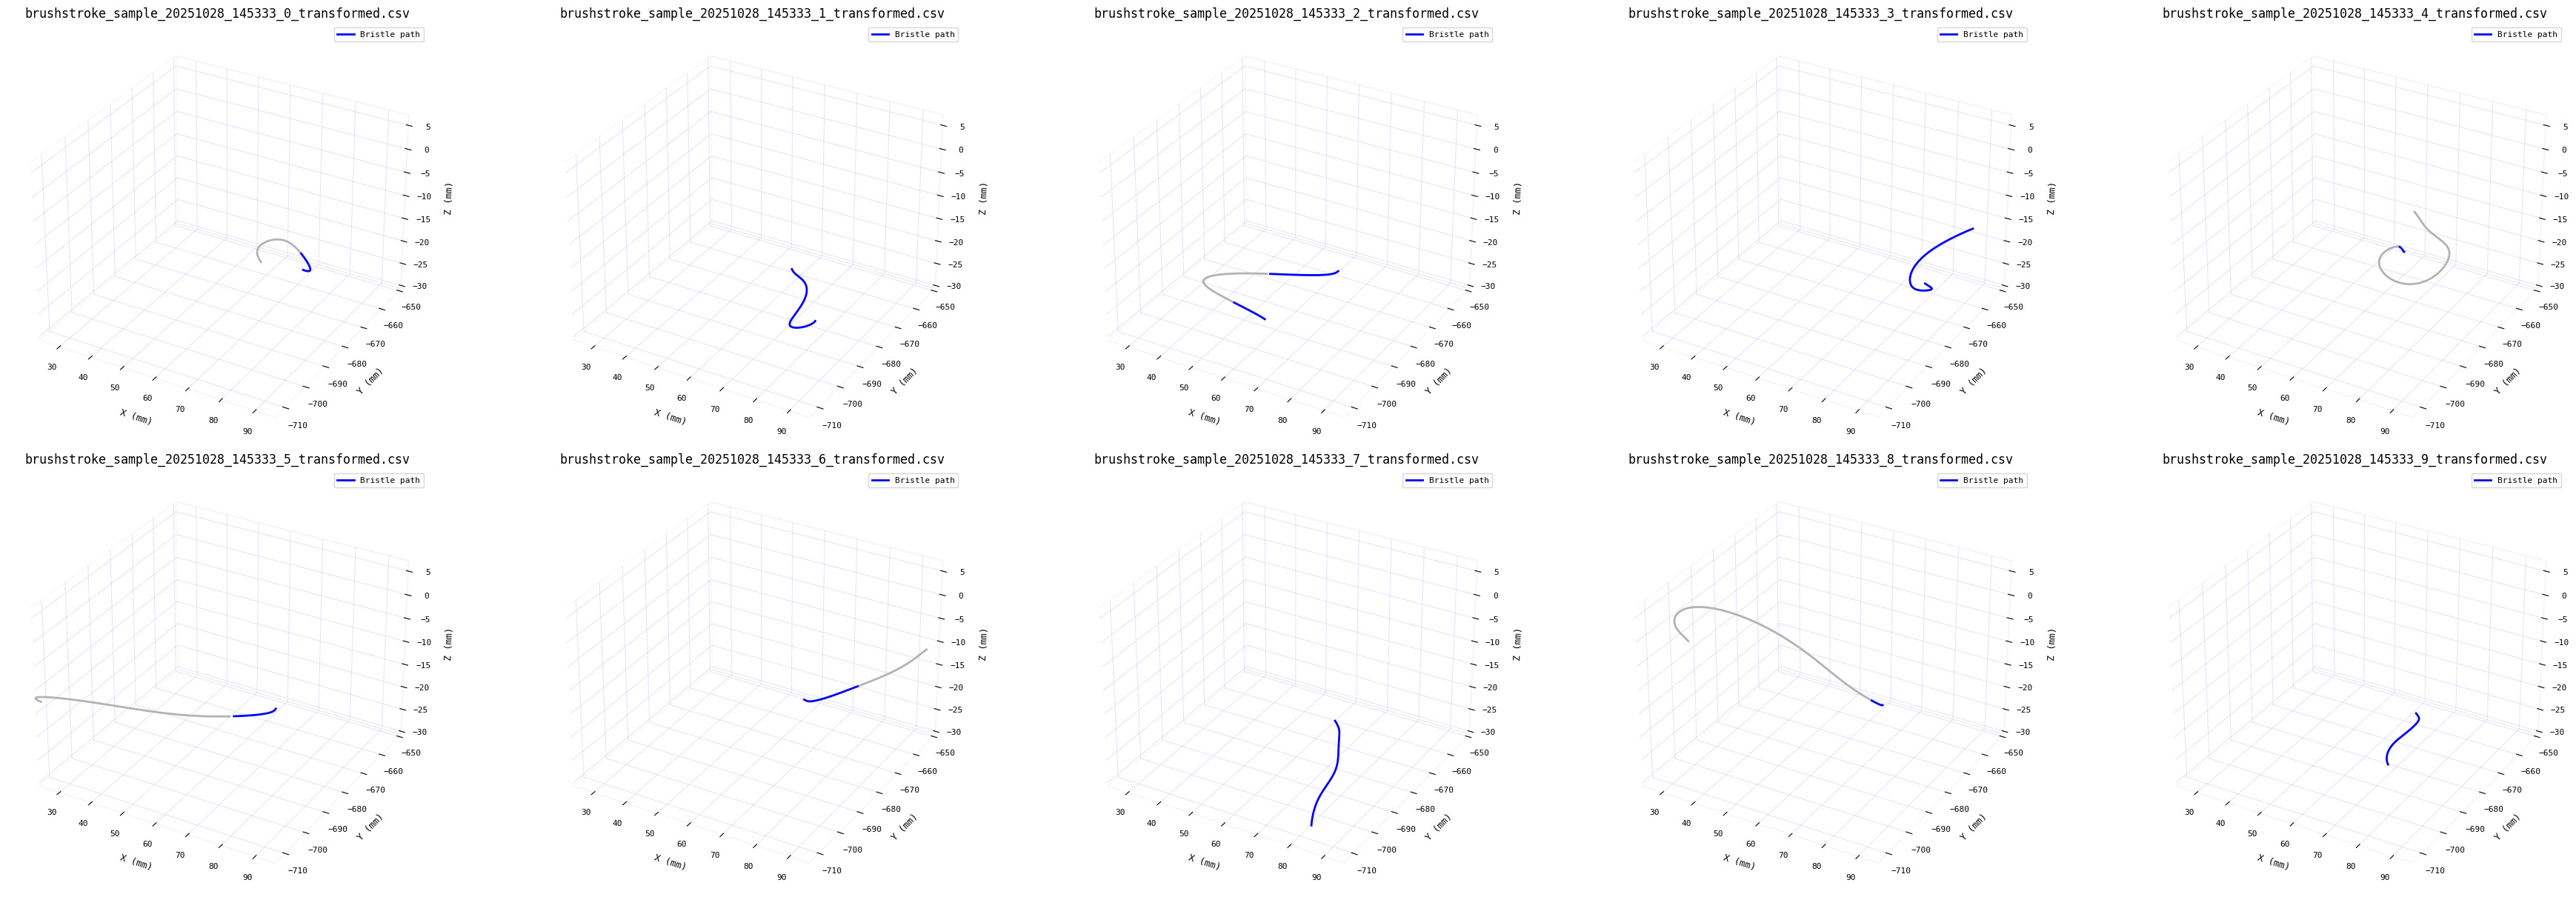

In [51]:
traj_plot(csv_path, len(csv_files), bristle_z_cutoff=-18)

## **Calculate Ferrule XYZ**

In [ ]:
# #old model was rotating in XYZ order, but KUKA does ZYX order
# def brush_xyz(X, Y, Z, alpha, beta, gamma, n=240.0):
#     """
#     Compute Tool 2 XYZ from a commanded pose (X,Y,Z, alpha,beta,gamma),
#     where alpha=rot about Z, beta=rot about Y, gamma=rot about X (KUKA ABC, Z-Y-X).
#     n is the offset of Tool 2 along the flange +Z (mm).
#     Angles in radians; distances in mm.
#     """
#     ca, sa = math.cos(alpha), math.sin(alpha)  # alpha -> about Z
#     cb, sb = math.cos(beta),  math.sin(beta)   # beta  -> about Y
#     cc, sc = math.cos(gamma), math.sin(gamma)  # gamma -> about X

#     # R = Rz(alpha) @ Ry(beta) @ Rx(gamma)
#     # Third column of R (local +Z expressed in world):
#     kx = ca*sb*cc + sa*sc
#     ky = sa*sb*cc - ca*sc
#     kz = cb*cc

#     return (X + n*kx, Y + n*ky, Z + n*kz)


In [13]:
def brushferrule_xyz_from_tip(X_tip, Y_tip, Z_tip, alpha, beta, gamma, n_bristle):
    """
    Compute the brush ferrule XYZ given the *brush tip* position and orientation.

    Parameters
    ----------
    X_tip, Y_tip, Z_tip : float
        World coordinates of the brush tip (mm)
    alpha, beta, gamma : float
        Tool orientation in radians (KUKA Z-Y-X order)
        alpha = rotation about Z
        beta  = rotation about Y
        gamma = rotation about X
    n_bristle : float
        Length of the bristles (tip Ã¢â€ â€™ ferrule) in mm

    Returns
    -------
    (Xf, Yf, Zf) : tuple of floats
        World coordinates of the ferrule
    """
    ca, sa = math.cos(alpha), math.sin(alpha)
    cb, sb = math.cos(beta),  math.sin(beta)
    cc, sc = math.cos(gamma), math.sin(gamma)

    # Local +Z axis expressed in world coordinates
    kx = ca*sb*cc + sa*sc
    ky = sa*sb*cc - ca*sc
    kz = cb*cc

    # Ferrule is behind the tip along +Z (toward handle)
    return (X_tip - n_bristle * kx,
            Y_tip - n_bristle * ky,
            Z_tip - n_bristle * kz)


In [6]:
n_bristle = 18.0  # mm

ferrule_xyz = brushferrule_xyz_from_tip(500, 200, 0, 0.1, 0.2, 0.3, -n_bristle)
print("Ferrule XYZ:", ferrule_xyz)


Ferrule XYZ: (503.93031193663404, 195.0482747482716, 16.853280544515584)


In [15]:
#Tool length (minus away bristles of 18mm)
n_bristle = 18

brush_csv = csv_files.copy()

for df in brush_csv:
    # create new columns for TCP coordinates
    df['ferrule_X_mm'] = 0.0
    df['ferrule_Y_mm'] = 0.0
    df['ferrule_Z_mm'] = 0.0

    # iterate over rows
    for i, row in df.iterrows():
        x, y, z = brushferrule_xyz_from_tip(
            row['X_mm'], row['Y_mm'], row['Z_mm'],
            row['alpha_rad'], row['beta_rad'], row['gamma_rad'], n_bristle
        )
        df.loc[i, 'ferrule_X_mm'] = x
        df.loc[i, 'ferrule_Y_mm'] = y
        df.loc[i, 'ferrule_Z_mm'] = z

In [66]:
true_paths = []
for df, path in zip(brush_csv, csv_path):
    out_path = outdir / f"{path.stem.replace('_transformed', '_zsafe')}.csv"
    df.to_csv(out_path, index=False)
    true_paths.append(out_path)

print(len(true_paths))
print(true_paths[0])

10
outputs\safe_samples\brushstroke_sample_20251028_145333_0_zsafe.csv


minimum z is -30.703888, maximum z is 9.863029493712167


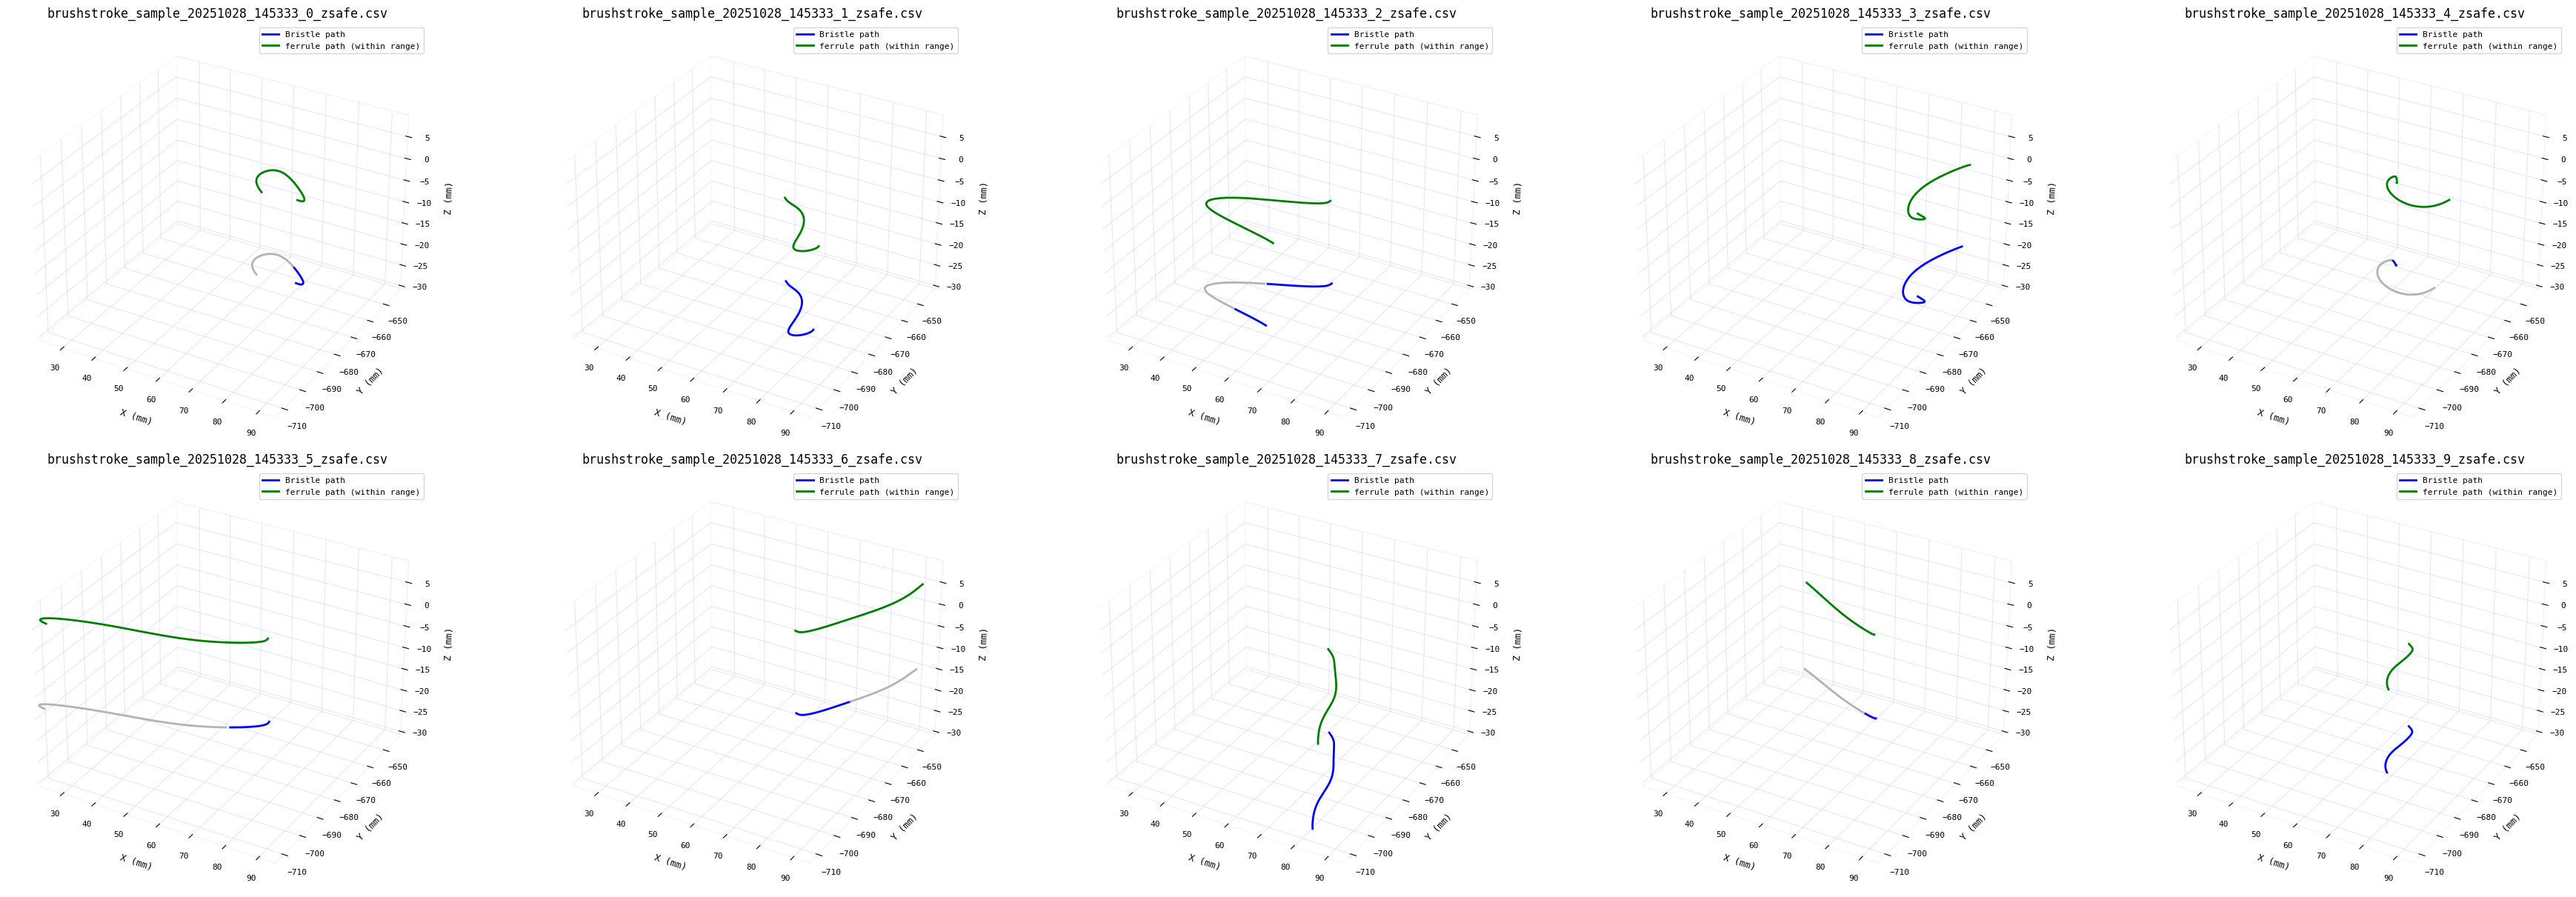

In [67]:
traj_plot(true_paths, len(true_paths), bristle_z_cutoff=-18, ferrule_z_range=(-17,10))

## **Fix Collisions**

*and save*

In [68]:
lower_limit = -18.0  # matches the ferrule_z_range lower bound used in the plots
clearance = 0.5
target_floor = lower_limit + clearance

collisionfree_csv = []
z_shifts = []

for idx, df in enumerate(brush_csv):
    if df.empty:
        collisionfree_csv.append(df.copy(deep=True))
        z_shifts.append(0.0)
        continue

    if "ferrule_Z_mm" not in df.columns:
        raise ValueError("ferrule_Z_mm column missing; run ferrule computation first")

    df_safe = df.copy(deep=True)
    min_ferrule = df_safe["ferrule_Z_mm"].min()
    shift = max(0.0, target_floor - min_ferrule)
    z_shifts.append(shift)

    if shift > 0:
        df_safe["Z_mm"] += shift
        df_safe["ferrule_Z_mm"] += shift

    collisionfree_csv.append(df_safe)

z_shifts = np.asarray(z_shifts, dtype=float)

if not collisionfree_csv:
    print("No trajectories loaded into brush_csv.")
else:
    adjusted_count = int((z_shifts > 0).sum())
    max_shift = float(z_shifts.max()) if adjusted_count else 0.0
    min_candidates = [
        df["ferrule_Z_mm"].min()
        for df in collisionfree_csv
        if "ferrule_Z_mm" in df.columns and not df.empty
    ]
    min_after = float(np.min(min_candidates)) if min_candidates else float("nan")

    print(
        f"Adjusted {adjusted_count} of {len(z_shifts)} trajectories. "
        f"Max upward shift: {max_shift:.3f} mm."
    )
    print(
        f"Minimum ferrule_Z_mm after adjustment: {min_after:.3f} mm "
        f"(target >= {target_floor:.3f} mm)."
    )


Adjusted 0 of 10 trajectories. Max upward shift: 0.000 mm.
Minimum ferrule_Z_mm after adjustment: -13.426 mm (target >= -17.500 mm).


In [69]:
collisionfree_paths = []
for df, path in zip(brush_csv, csv_path):
    out_path = outdir / f"{path.stem.replace('_transformed', '_zsafe')}.csv"
    df.to_csv(out_path, index=False)
    collisionfree_paths.append(out_path)

print(len(collisionfree_paths))
print(collisionfree_paths[0])

10
outputs\safe_samples\brushstroke_sample_20251028_145333_0_zsafe.csv


minimum z is -30.703888, maximum z is 9.863029493712167


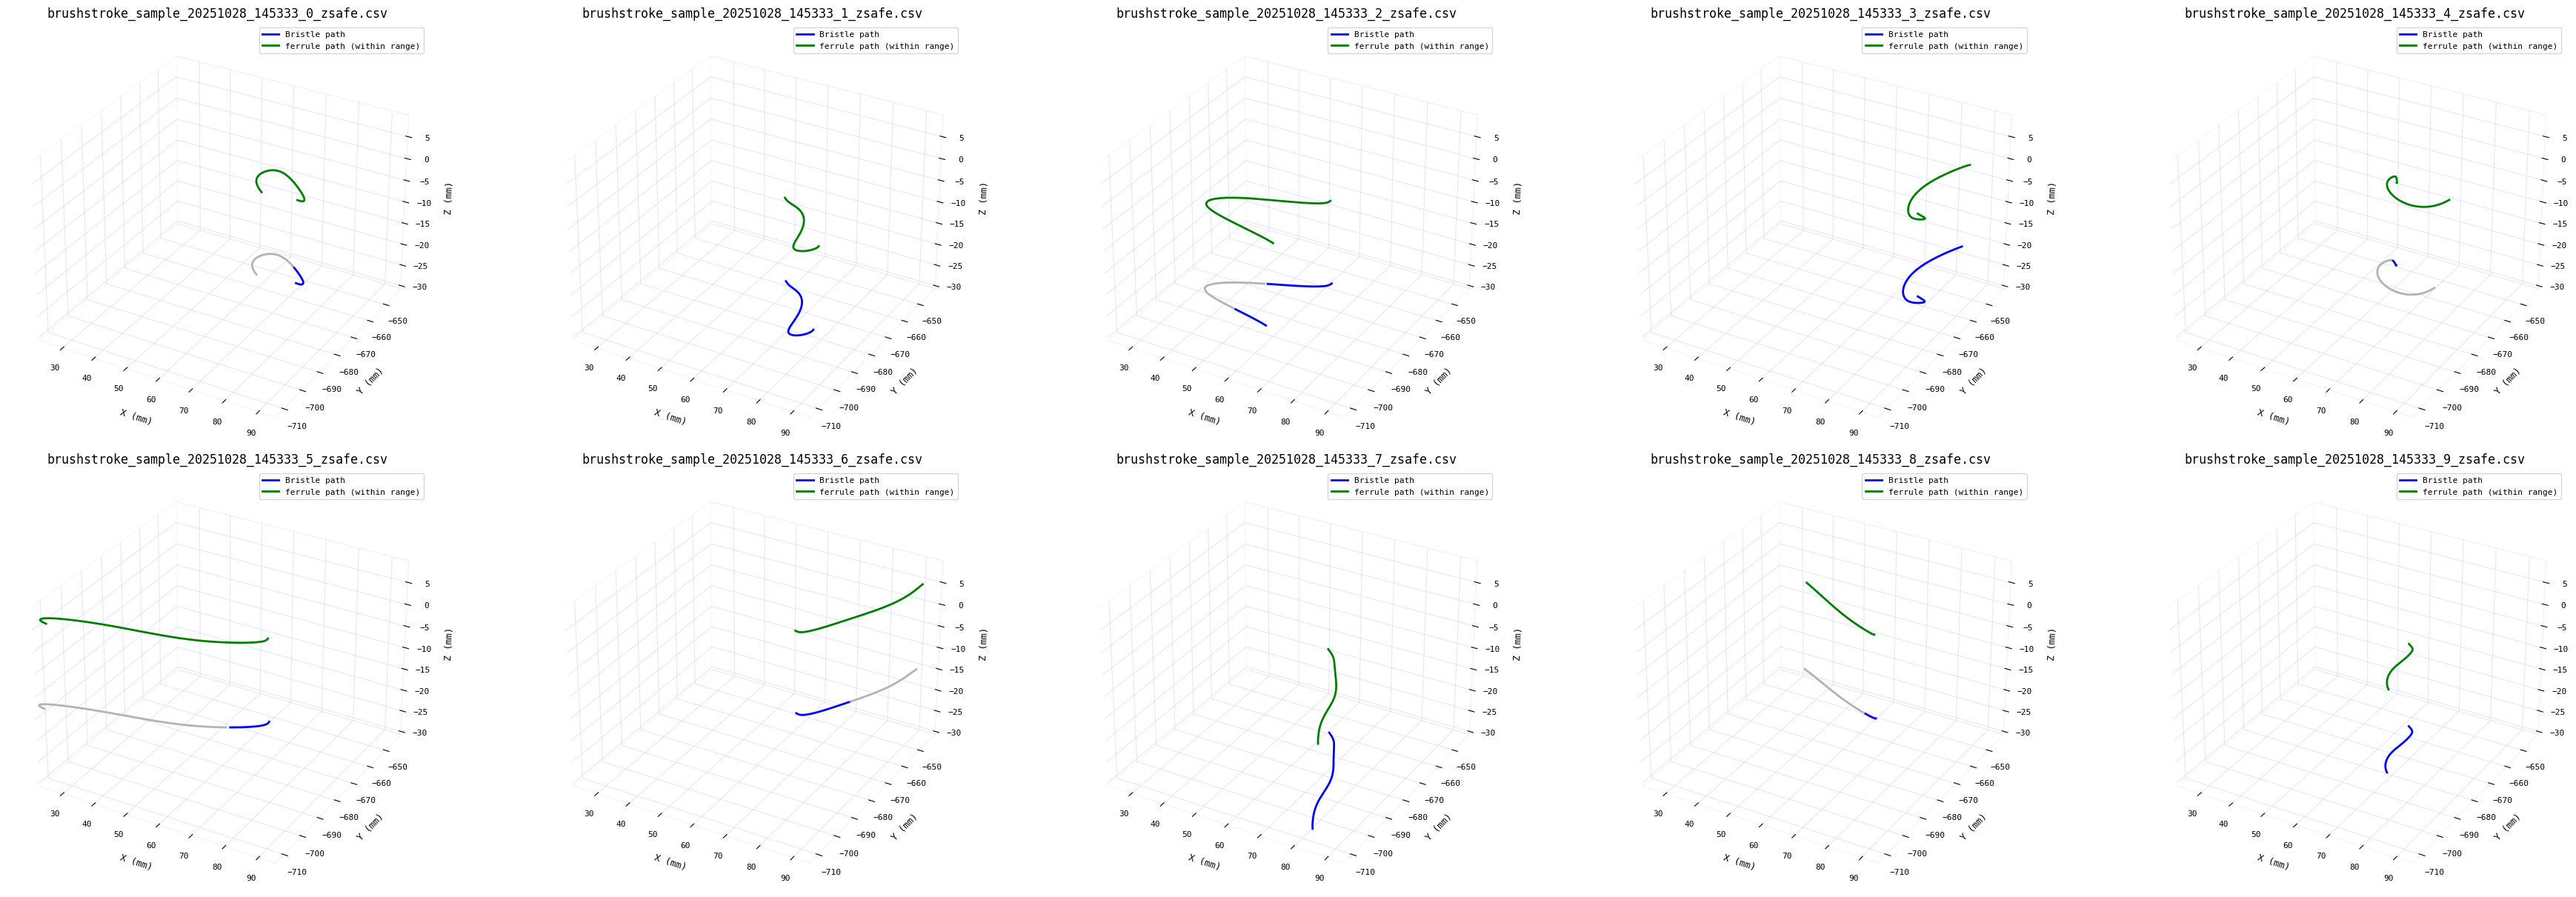

In [70]:
traj_plot(collisionfree_paths, len(collisionfree_paths), bristle_z_cutoff=-18, ferrule_z_range=(-18,10))